In [530]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,PowerTransformer,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,f1_score,precision_score,recall_score

In [531]:
df = pd.read_csv(".//data//heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [532]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [533]:
numerical_column=['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']
label= 'HeartDisease'
categorical_column = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

In [534]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [535]:
def hist_box_plot(data, target=None, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    if target is not None:
        for label in np.unique(target):
            plt.hist(data[target == label], alpha=0.5, label=f'Target {label}')
        plt.legend()
    else:
        plt.hist(data)
    plt.title(f'{title} - Histogram')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.subplot(1,2,2)
    if target is not None:
        sns.boxplot(x=target, y=data)
    else:
        sns.boxplot(x=data)
    plt.title(f'{title} - Boxplot')
    plt.xlabel('Target' if target is not None else xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def bar_plot(data, target=None, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(5,3))
    
    if target is not None:
        temp_df = pd.DataFrame({ 'feature': data, 'target': target })
        sns.countplot(x='feature', hue='target', data=temp_df)
    else:
        counts = data.value_counts()
        plt.bar(counts.index, counts.values)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

def heatmap(data):
    sns.heatmap(data,annot=True,cmap='Blues',fmt = '.2f')
    plt.show()

def evaluate_classification(y_true,y_pred,return_dict=False):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    if return_dict:
        return {
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
        }
    else:
        print(f'Accuracy: {acc}')
        print(f'Precision: {prec}')
        print(f'Recall: {rec}')
        print(f'F1-Score: {f1}')

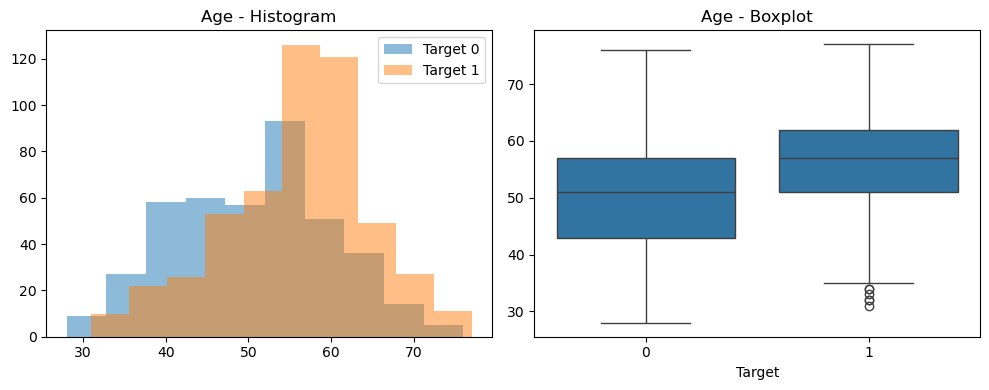

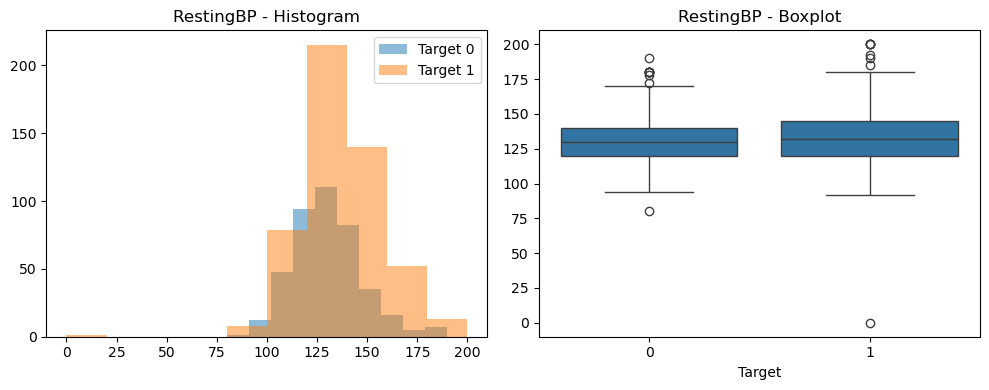

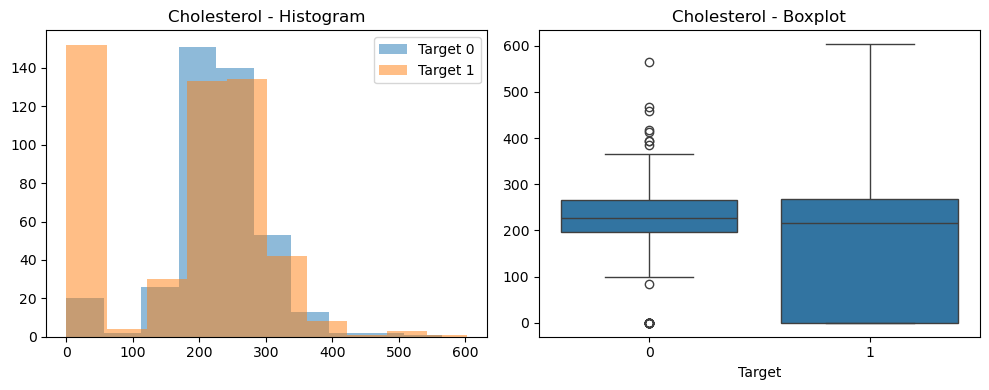

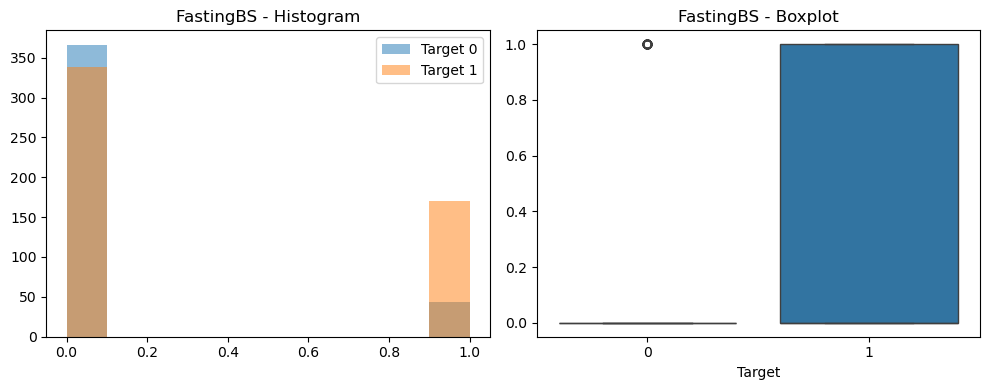

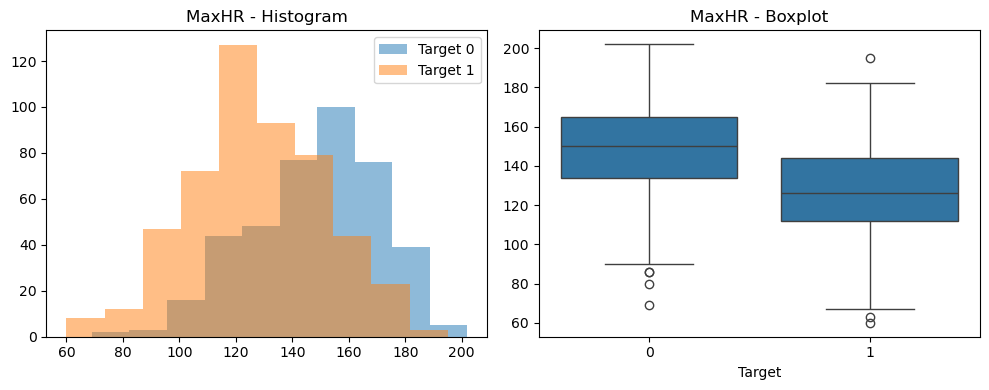

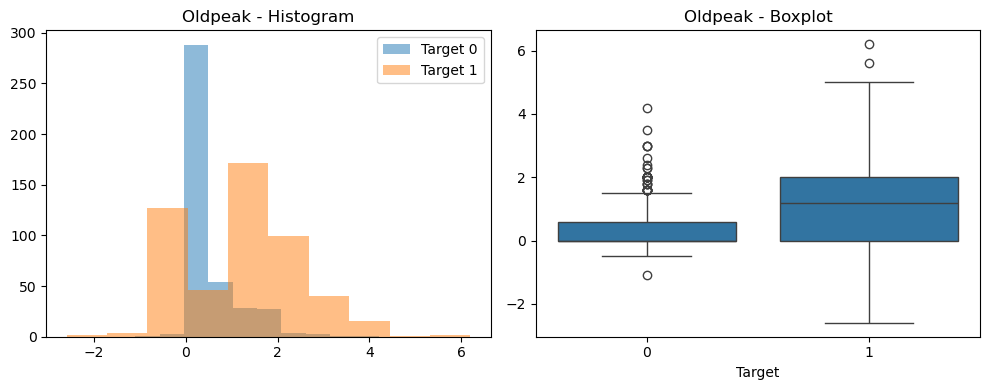

In [536]:
for column in numerical_column:
    hist_box_plot(df[column],title=column,target = df[label])

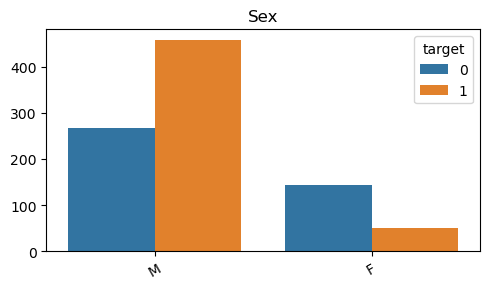

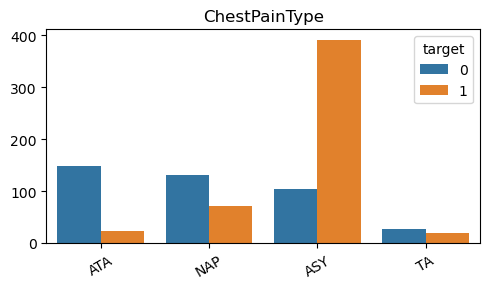

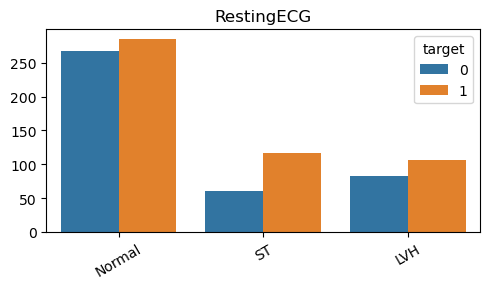

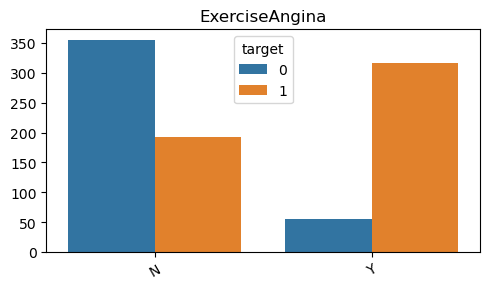

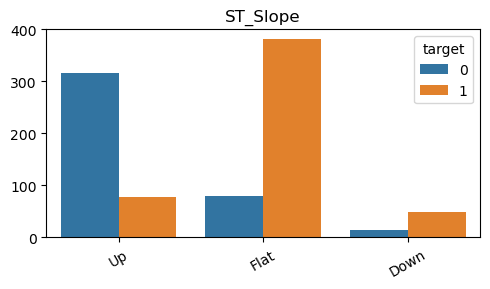

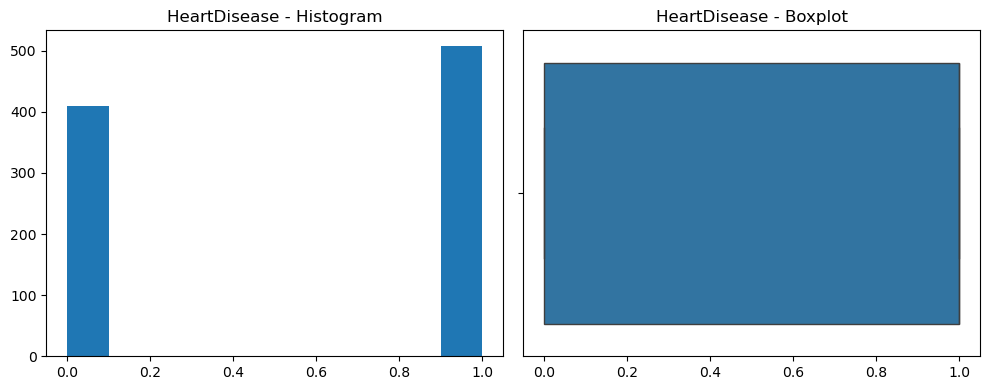

In [537]:
for column in categorical_column:
    bar_plot(df[column],title=column,target=df['HeartDisease'])
hist_box_plot(df[label],title=label)

In [538]:
def evaluate_models(df):
    results = []
    X = df.drop('HeartDisease',axis=1)
    y = df['HeartDisease']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)
    transformer = ColumnTransformer([
        ('num', MinMaxScaler(), numerical_column),
        # ('num', StandardScaler(), numerical_column),
        ('categorical',OneHotEncoder(),categorical_column)
    ])

    models = {
        'LogisticRegression':LogisticRegression(random_state=42,max_iter=500),
        'RandomForestClassifier':RandomForestClassifier(random_state=42),
        'XGBClassifier':XGBClassifier(random_state=42)
    }

    for name,model in models.items():
        pipeline = Pipeline([
            ('transformer',transformer),
            ('classifier',model)
        ])
        pipeline.fit(X_train,y_train)
        y_pred = pipeline.predict(X_test)
        scores = evaluate_classification(y_pred=y_pred,y_true=y_test,return_dict=True)
        scores['Model'] = name
        results.append(scores)

    df_results = pd.DataFrame(results)
    return models,df_results.sort_values(by=['F1-Score'],ascending=False)

In [541]:
baseline_model,baseline_result = evaluate_models(df)
baseline_result

,Accuracy,Precision,Recall,F1-Score,Model
1,0.88587,0.913462,0.887850,0.900474,RandomForestClassifier
2,0.87500,0.903846,0.878505,0.890995,XGBClassifier
0,0.86413,0.901961,0.859813,0.880383,LogisticRegression


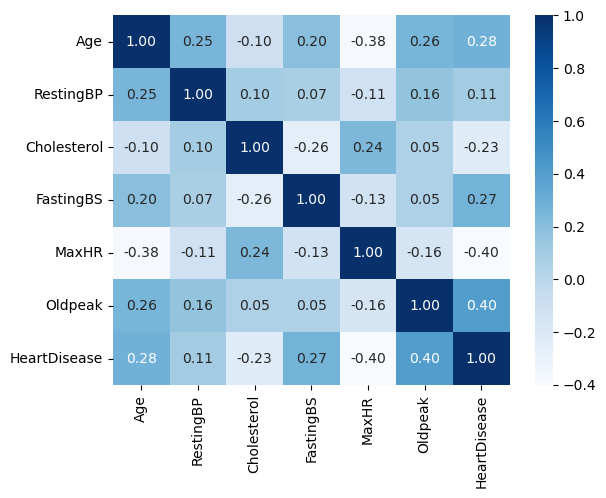

In [496]:
heatmap(df.corr(numeric_only=True))

In [542]:
# df['Age_group'] = pd.cut(df['Age'],bins = [0,30,50,80],labels=['Muda','Paruh_Baya','Tua'])
# categorical_column.append('Age_group')
# bar_plot(df['Age_group'],target=df['HeartDisease'])
# df.head(2)

In [498]:
# df = df.drop('Age',axis=1)
# numerical_column.remove('Age')

In [515]:
evaluate_models(df)[1],baseline_result

(   Accuracy  Precision    Recall  F1-Score                   Model
 2  0.875000   0.903846  0.878505  0.890995           XGBClassifier
 0  0.858696   0.900990  0.850467  0.875000      LogisticRegression
 1  0.853261   0.892157  0.850467  0.870813  RandomForestClassifier,
    Accuracy  Precision    Recall  F1-Score                   Model
 1   0.88587   0.913462  0.887850  0.900474  RandomForestClassifier
 2   0.87500   0.903846  0.878505  0.890995           XGBClassifier
 0   0.86413   0.901961  0.859813  0.880383      LogisticRegression)

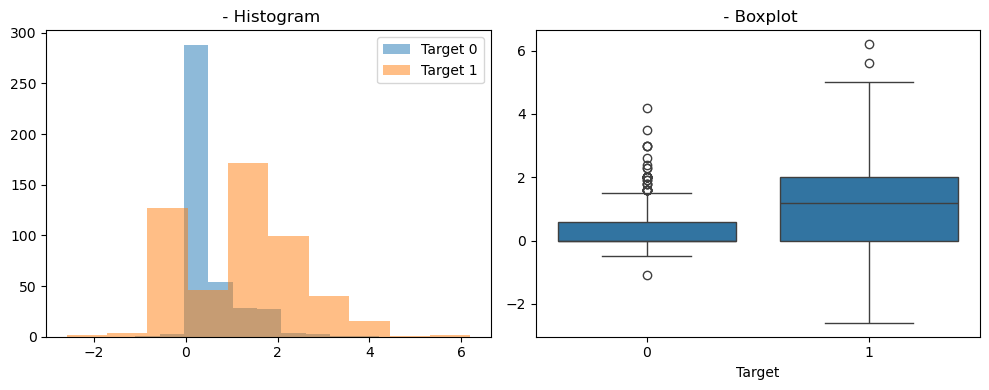

In [433]:
hist_box_plot(df['Oldpeak'],target=df['HeartDisease'])

c:\Users\Sanju\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Sanju\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, 1.9740810260220096] is not finite

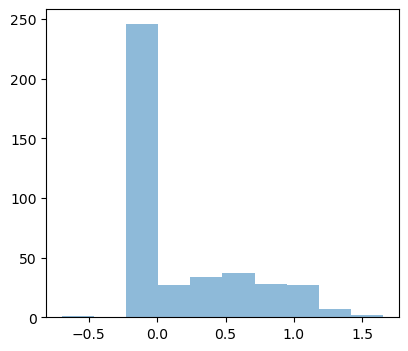

In [434]:
pt = PowerTransformer()
df['Oldpeak'] = np.log1p(df['Oldpeak'])
hist_box_plot(df['Oldpeak'],target=df['HeartDisease'])